In [43]:
from PIL import Image
import numpy as np
import cv2
import random

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e  import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

import matplotlib.pyplot as plt
%matplotlib inline

target_image_size = 256

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

def load_anno():
    video_dir = '/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages'
    list_path = '/home/lr/dataset/YouTube-VOS/2018/youtube2018_train_list.txt'

    samples = []

    with open(list_path, 'r') as f:
        for idx, line in enumerate(f.readlines()):
            sample = dict()
            vname, num_frames = line.strip('\n').split()
            sample['frames_path'] = sorted(glob.glob(osp.join(video_dir, vname, '*.jpg')))
            sample['num_frames'] = int(num_frames)
            samples.append(sample)
    return samples

def visualize_vqvae(z1_q, z2_q, frame1, frame2, x_rec1, x_rec2):
    frame_vq_1 = z1_q.permute(1,2,0).numpy()
    frame_vq_2 = z2_q.permute(1,2,0).numpy()


    frame_vq_1 = (frame_vq_1 * 255 / 8192).astype(np.uint8)
    frame_vq_2 = (frame_vq_2 * 255 / 8192).astype(np.uint8)

    v1 = cv2.applyColorMap(frame_vq_1, cv2.COLORMAP_JET)
    v2 = cv2.applyColorMap(frame_vq_2, cv2.COLORMAP_JET)


    plt.rcParams['figure.dpi'] = 200

    plt.figure()
    plt.subplot(3,2,1)
    plt.imshow(v1)
    plt.subplot(3,2,2)
    plt.imshow(v2)

    plt.subplot(3,2,3)
    plt.imshow(np.array(frame1))

    plt.subplot(3,2,4)
    plt.imshow(np.array(frame2))

    plt.subplot(3,2,5)
    plt.imshow(np.array(x_rec1))

    plt.subplot(3,2,6)
    plt.imshow(np.array(x_rec2))

    plt.show()

def visualize_correspondence(z1_q, z2_q, sample_idx, frame1, frame2, scale=32):
    plt.rcParams['figure.dpi'] = 200

    z1_q = z1_q[0].numpy()
    z2_q = z2_q[0].numpy()
    find = False
    count = 0

    while not find:
        x, y = sample_idx % scale, sample_idx // scale

        query = z1_q[y,x]
        m = (z2_q == query).astype(np.uint8) * 255
        count += 1

        if m.max() > 1:
            find = True
        else:
            sample_idx = random.randint(0, scale*scale -1)
            print('not find, change query')
        
    print(f"find correspodence at {count}")   

    querys_map = np.zeros((scale,scale))
    querys_map[y,x] = 255
    querys_map = querys_map.astype(np.uint8)
    querys_map = cv2.applyColorMap(querys_map, cv2.COLORMAP_JET)
    matches_map = cv2.applyColorMap(m, cv2.COLORMAP_JET)

    plt.figure()
    plt.subplot(2,2,1)
    plt.imshow(querys_map)
    plt.subplot(2,2,2)
    plt.imshow(matches_map)

    plt.subplot(2,2,3)
    plt.imshow(np.array(frame1))

    plt.subplot(2,2,4)
    plt.imshow(np.array(frame2))

In [44]:
# build model
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cpu')

# For faster load times, download these files locally and use the local paths instead.
enc = load_model("/home/lr/models/vqvae/dalle/encoder.pkl", dev)
dec = load_model("/home/lr/models/vqvae/dalle/decoder.pkl", dev)

In [45]:
# sample frame
import os.path as osp
import glob

# samples = load_anno()

# video_idx = random.randint(0, len(samples) - 1)
# frame_idx = random.randint(0, samples[video_idx]['num_frames'] - 2)
# sample = samples[video_idx]
# frame1 = Image.open(sample['frames_path'][frame_idx]).convert('RGB')
# frame2 = Image.open(sample['frames_path'][frame_idx+1]).convert('RGB')
# print('sample frames from {}'.format(sample['frames_path'][0]))


frame1 = Image.open('/home/lr/dataset/YouTube-VOS/2019/train/JPEGImages/0358b938c1/00220.jpg').convert('RGB')
frame2 = Image.open('/home/lr/dataset/YouTube-VOS/2019/train/JPEGImages/0358b938c1/00225.jpg').convert('RGB')

x1 = preprocess(frame1)
x2 = preprocess(frame2)

from IPython.display import display, display_markdown

frame1 = T.ToPILImage(mode='RGB')(x1[0])
frame2 = T.ToPILImage(mode='RGB')(x2[0])

In [46]:
# encode and decode for dalle
z_logits1 = enc(x1)
z1_q = torch.argmax(z_logits1, axis=1)

z1 = F.one_hot(z1_q, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
x_stats1 = dec(z1).float()
x_rec1 = unmap_pixels(torch.sigmoid(x_stats1[:, :3]))
x_rec1 = T.ToPILImage(mode='RGB')(x_rec1[0])

z_logits2 = enc(x2)
z2_q = torch.argmax(z_logits2, axis=1)

z2 = F.one_hot(z2_q, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
x_stats2 = dec(z2).float()
x_rec2 = unmap_pixels(torch.sigmoid(x_stats2[:, :3]))
x_rec2 = T.ToPILImage(mode='RGB')(x_rec2[0])

In [50]:
# encode and decode for origin vqvae
from vqvae import VQVAE
model = VQVAE(downsample=2, n_embed=4096)

model.load_state_dict(torch.load('vqvae_d2_n4096.pth'))
model = model.cuda()
_, quant, diff, ind1, embed = model.encode(x1.cuda())
_, quant, diff, ind2, embed = model.encode(x2.cuda())

4


RuntimeError: Error(s) in loading state_dict for VQVAE:
	Missing key(s) in state_dict: "enc.blocks.6.weight", "enc.blocks.6.bias", "enc.blocks.7.conv.1.weight", "enc.blocks.7.conv.1.bias", "enc.blocks.7.conv.3.weight", "enc.blocks.7.conv.3.bias", "enc.blocks.8.conv.1.weight", "enc.blocks.8.conv.1.bias", "enc.blocks.8.conv.3.weight", "enc.blocks.8.conv.3.bias", "dec.blocks.8.weight", "dec.blocks.8.bias". 
	Unexpected key(s) in state_dict: "enc.blocks.5.conv.1.weight", "enc.blocks.5.conv.1.bias", "enc.blocks.5.conv.3.weight", "enc.blocks.5.conv.3.bias", "enc.blocks.6.conv.1.weight", "enc.blocks.6.conv.1.bias", "enc.blocks.6.conv.3.weight", "enc.blocks.6.conv.3.bias". 
	size mismatch for enc.blocks.2.weight: copying a param with shape torch.Size([128, 64, 4, 4]) from checkpoint, the shape in current model is torch.Size([64, 64, 4, 4]).
	size mismatch for enc.blocks.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for enc.blocks.4.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 4, 4]).
	size mismatch for quantize.embed: copying a param with shape torch.Size([64, 4096]) from checkpoint, the shape in current model is torch.Size([64, 2048]).
	size mismatch for quantize.cluster_size: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for quantize.embed_avg: copying a param with shape torch.Size([64, 4096]) from checkpoint, the shape in current model is torch.Size([64, 2048]).
	size mismatch for dec.blocks.6.weight: copying a param with shape torch.Size([64, 3, 4, 4]) from checkpoint, the shape in current model is torch.Size([64, 64, 4, 4]).
	size mismatch for dec.blocks.6.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([64]).

not find, change query
not find, change query
not find, change query
not find, change query
not find, change query
not find, change query
not find, change query
not find, change query
find correspodence at 9


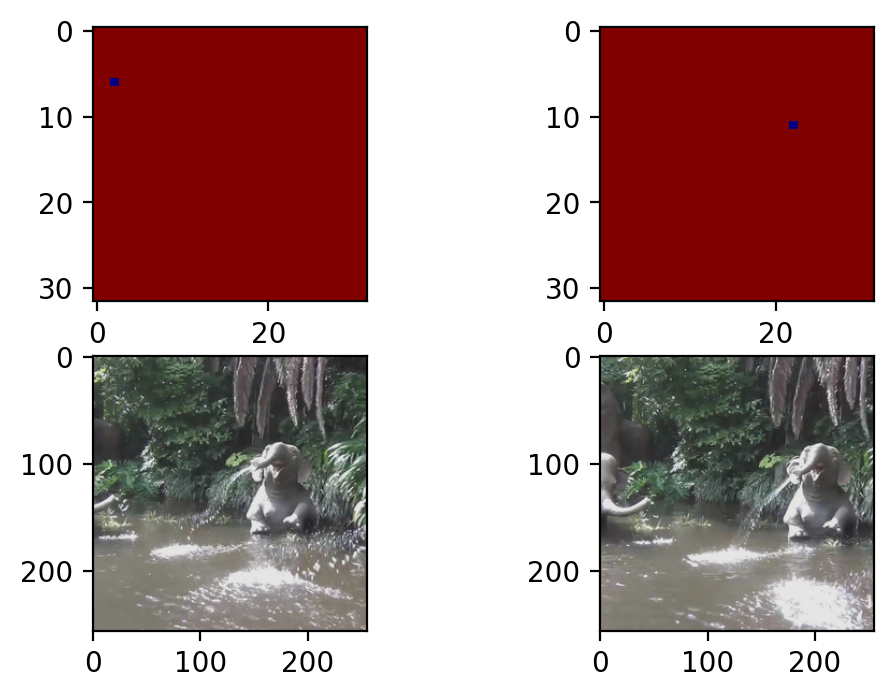

In [ ]:
# visualize corr for dalle
sample_idx = random.randint(0, 32*32 -1)
visualize_correspondence(z1_q, z2_q, sample_idx, frame1, frame2)

In [ ]:
# visualize corr for origin vqvae
sample_idx = random.randint(0, 64*64 -1)
visualize_correspondence(ind1.cpu(), ind2.cpu(), sample_idx, frame1, frame2, scale=64)

IndexError: index 63 is out of bounds for axis 0 with size 32